In [ ]:
#!python3.11 -m pip install jupyter matplotlib torch torchvision

In [113]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision.transforms.v2 as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Data augmenter with Moffat blur Transform

In [138]:
class RandomColorChannel(T.Transform):
    def __init__(self):
        super().__init__()
    
    def transform(self, inpt, params):
        if (torch.rand(1).item() < .33):
            return inpt.getchannel('R')  # Select the red channel
        elif (torch.rand(1).item() < .67):
            return inpt.getchannel('G')  # Select the green channel
        else:
            return inpt.getchannel('B')  # Select the blue channel

In [224]:
class MoffatBlur(T.Transform):
    def __init__(self, size=15, alpha=3.0, beta=2.5):
        super().__init__()
        self.size = size
        self.alpha = alpha
        self.beta = beta
        self.kernel = self._create_kernel(size, alpha, beta)

    def _create_kernel(self, size, alpha, beta):
        center = size // 2
        y, x = torch.meshgrid(torch.arange(size), torch.arange(size), indexing='ij')
        y = y - center
        x = x - center
        r2 = x**2 + y**2
        kernel = (1 + (r2 / alpha**2)) ** (-beta)
        kernel /= kernel.sum()
        return kernel

    def _apply_blur(self, img):
        # img shape (C, H, W), assume C=1 or 3
        C, H, W = img.shape
        kernel = self.kernel.to(img.device).unsqueeze(0).unsqueeze(0)
        kernel = kernel.expand(C, 1, self.size, self.size)
        padding = self.size // 2
        img = img.float()
        img = img.unsqueeze(0)  # batch dim
        blurred = F.conv2d(img, kernel, padding=padding, groups=C)
        return blurred.squeeze(0)

    def transform(self, inpt, params):
        # inpt is torch.Tensor CxHxW, values in [0,1]
        img = self._apply_blur(inpt)

        img = (img - img.min()) / (img.max() - img.min())

        return img

In [225]:
transform = T.Compose([
    T.RandomResizedCrop(size=(256,256)),
    T.RandomHorizontalFlip(p=0.5),
    T.ToImage(),  # convertit PIL Image en tensor CxHxW en [0,1]
    MoffatBlur(size=15, alpha=3.0, beta=2.5),
])


# Data Loader

In [230]:
class JPGFolderDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = [
            os.path.join(folder_path, f)
            for f in os.listdir(folder_path)
            if f.lower().endswith(".jpg")
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        img_tensor = T.ToImage()(image)

        channel_idx = max(2, np.floor(3*torch.rand(1).item()))
        
        # Extraction du canal choisi -> shape (H, W)
        mono_channel = img_tensor[channel_idx, :, :]
        
        # Ajout de la dimension canal -> shape (1, H, W)
        mono_channel = mono_channel.unsqueeze(0)

        # Appliquer la transformation si définie (sur ce canal)
        if self.transform:
            mono_channel = self.transform(mono_channel)

        return mono_channel


In [231]:
def batchShow(batch, title=None, cmap='gray', normalize=True):
    """
    Plots a batch of images in an 8x2 grid (16 images max).

    Args:
        batch (Tensor): (B, C, H, W) tensor, typically B <= 16.
        title (str): Optional title for the whole figure.
        cmap (str): Colormap for grayscale ('gray' by default).
        normalize (bool): Whether to denormalize from [-1,1] to [0,1].
    """
    batch = batch.detach().cpu()
    print(batch.shape, batch.min().item(), batch.max().item())
    
    B = min(batch.size(0), 16)
    C = batch.size(1)

    # Normalize from [-1, 1] to [0, 1] if needed
    if normalize:
        batch = (batch + 1.0) / 2.0
        batch = torch.clamp(batch, 0, 1)

    fig, axs = plt.subplots(2, 8, figsize=(16, 4))
    axs = axs.flatten()

    for i in range(16):
        axs[i].axis('off')
        if i >= B:
            axs[i].imshow(torch.ones(256, 256), cmap='gray')  # empty slot
        else:
            img = batch[i]
            if C == 1:
                axs[i].imshow(img.squeeze(0), cmap=cmap)
            elif C == 3:
                axs[i].imshow(img.permute(1, 2, 0))
            else:
                axs[i].imshow(img[0].cpu(), cmap=cmap)  # fallback

    if title:
        fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

In [232]:
dataset = JPGFolderDataset("data", transform=transform)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

torch.Size([16, 1, 256, 256]) 0.0 1.0


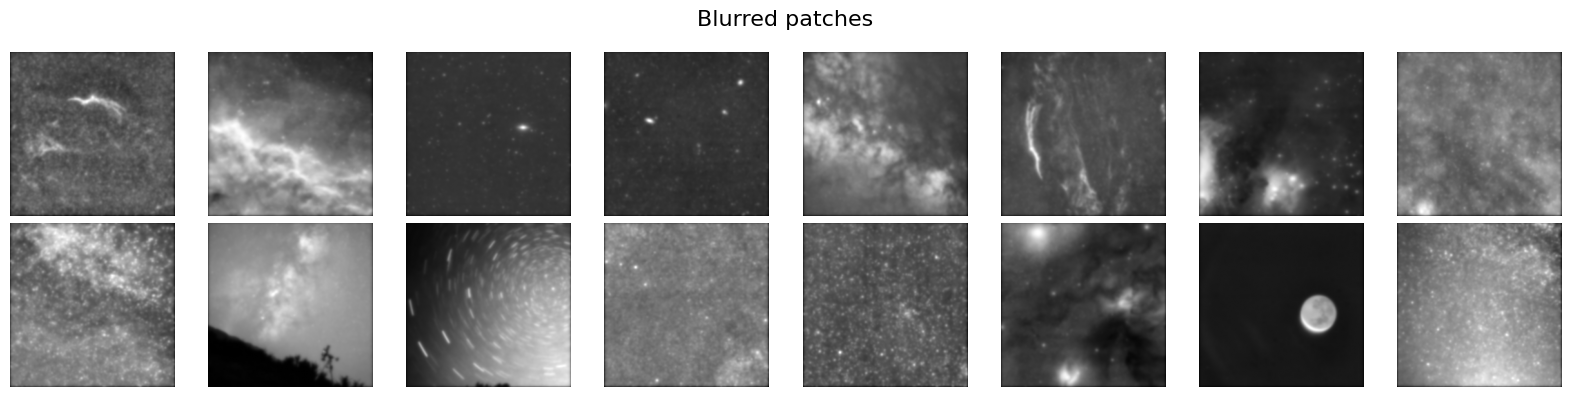

In [233]:
for batch in loader:
    batchShow(batch, title="Blurred patches")
    break